# Neural Network

## Table of content

- [Experiment on how imbalance affect the performance](#experiment-on-how-imbalance-affect-the-performance)
    - [Without handling imbalance](#Without-handling-imbalance)
    - [Using class weights](#Using-class-weights)
    - [Using oversampling ](#Using-oversampling )
    - [Results of the experiment](#Results-of-the-experiment)
- [Find the best model](#Find-the-best-model)

In [15]:
from Functions import get_result, plot_precision_recall_vs_threshold, plot_roc_curve
from keras import Sequential, models, utils
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, BatchNormalization
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, Precision, Recall, F1Score, AUC
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.utils import class_weight
import datetime
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Load the datasets for training (remember they are scaled)

In [3]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

We will start by creating a function to produce some plots of the models performance and loss on the training and validation set. These will help us check for overfitting.

In [33]:
def plot_training_metrics(history):
    metrics = ['loss', 'Recall', 'Precision', 'prc']
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

Now, lets do an experiment of how our neural network would do, when we do not handle the imbalance in our dataset. Afterwards we'll try two different techniques to handle the imbalance.

## Experiment on how imbalance affect the performance
We'll create a function to create a simple model, which we can use for this experiment.

In [5]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(),
                    loss=BinaryCrossentropy(from_logits=False),
                    metrics=[
                        BinaryAccuracy(name='Accuracy'),
                        Precision(name='Precision'), 
                        Recall(name='Recall'), 
                        AUC(name='PRC', curve='PR')
                    ])

    return model

In [6]:
BATCH_SIZE = 1024

### Without handling imbalance

In [11]:
model = get_simple_model()

In [13]:
history_unhandled = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
267/267 [==============================] - 3s 11ms/step - loss: 0.0106 - Accuracy: 0.9986 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - PRC: 0.0021 - val_loss: 0.0096 - val_Accuracy: 0.9988 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_PRC: 0.0017
Epoch 2/20
267/267 [==============================] - 3s 9ms/step - loss: 0.0103 - Accuracy: 0.9986 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - PRC: 0.0075 - val_loss: 0.0096 - val_Accuracy: 0.9988 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_PRC: 0.0044
Epoch 3/20
267/267 [==============================] - 2s 9ms/step - loss: 0.0101 - Accuracy: 0.9986 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - PRC: 0.0130 - val_loss: 0.0095 - val_Accuracy: 0.9988 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_PRC: 0.0098
Epoch 4/20
267/267 [==============================] - 2s 9ms/step - loss: 0.0099 - Accuracy: 0.9986 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - PRC: 0.0162 - val_loss: 0.0091 - val

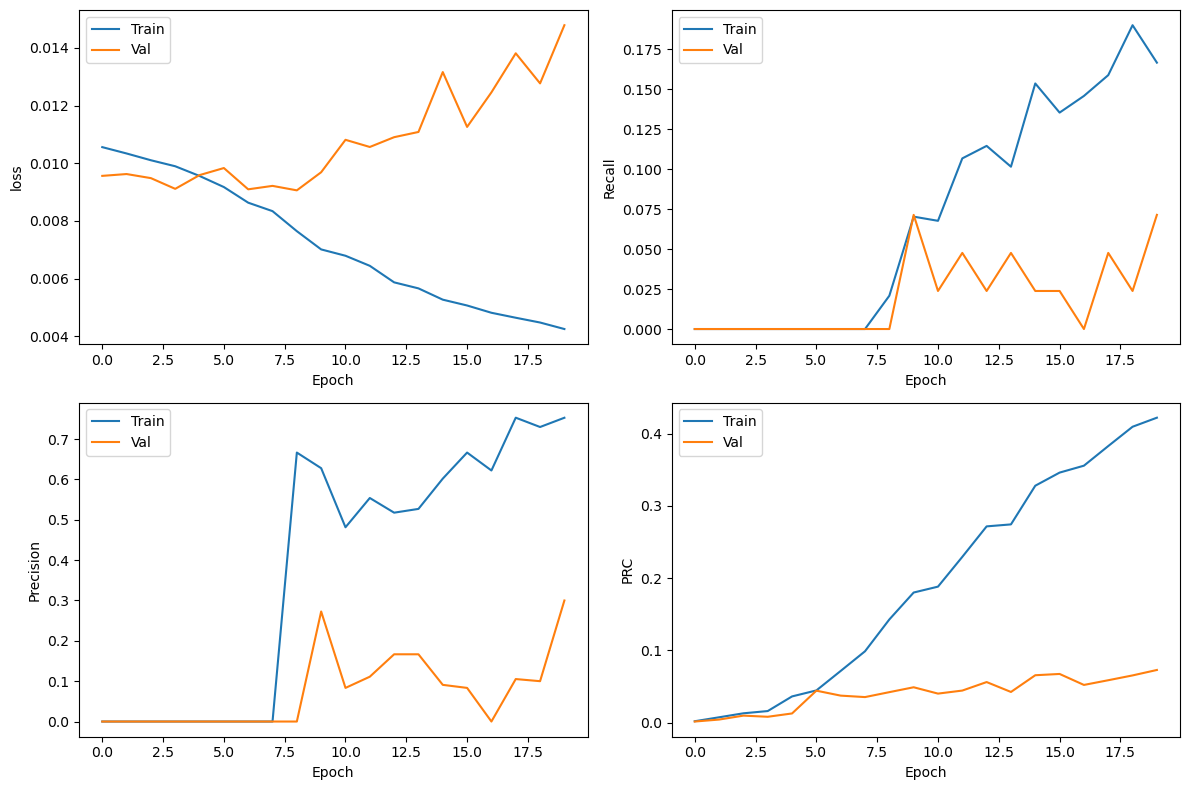

In [14]:
plot_training_metrics(history_unhandled)

In [15]:
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

34/34 [==============================] - 0s 2ms/step


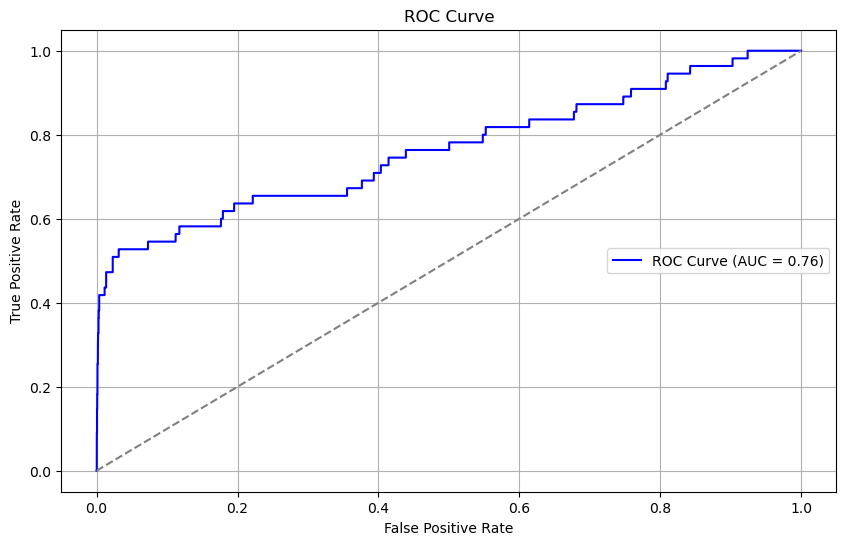

In [16]:
plot_roc_curve(Y_test, test_predictions)

/home/ykh/Repos/CreditCardApproval/Models/Functions.py:32: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


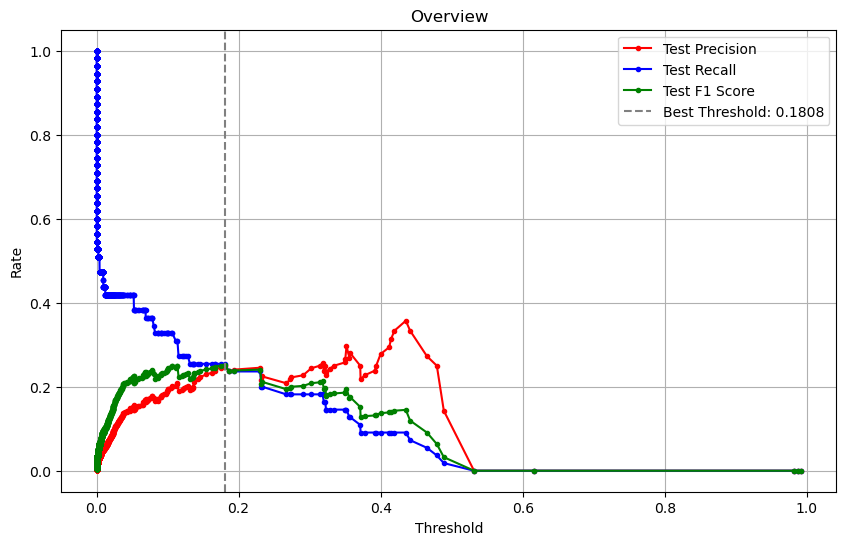

In [18]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

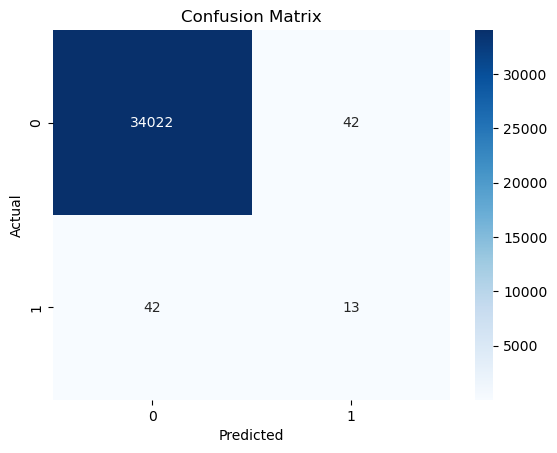

Recall       = 0.24
Precision    = 0.24
F1           = 0.24


In [20]:
get_result(Y_test, test_predictions, best_threshold)

### Using class weights

In [22]:
# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.5007044320516584, 1: 355.3958333333333}

In [24]:
model = get_simple_model()

history_class_weights = model.fit(
    X_train,
    Y_train,
    class_weight=class_weights_dict,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
267/267 [==============================] - 4s 11ms/step - loss: 0.6993 - Accuracy: 0.5245 - Precision: 0.0015 - Recall: 0.5182 - PRC: 0.0017 - val_loss: 0.6831 - val_Accuracy: 0.6003 - val_Precision: 0.0015 - val_Recall: 0.4762 - val_PRC: 0.0020
Epoch 2/20
267/267 [==============================] - 3s 10ms/step - loss: 0.6788 - Accuracy: 0.5076 - Precision: 0.0019 - Recall: 0.6641 - PRC: 0.0022 - val_loss: 0.6668 - val_Accuracy: 0.6051 - val_Precision: 0.0017 - val_Recall: 0.5476 - val_PRC: 0.0024
Epoch 3/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6433 - Accuracy: 0.6546 - Precision: 0.0026 - Recall: 0.6328 - PRC: 0.0034 - val_loss: 0.6246 - val_Accuracy: 0.6494 - val_Precision: 0.0019 - val_Recall: 0.5476 - val_PRC: 0.0031
Epoch 4/20
267/267 [==============================] - 3s 10ms/step - loss: 0.6072 - Accuracy: 0.6973 - Precision: 0.0030 - Recall: 0.6380 - PRC: 0.0066 - val_loss: 0.8613 - val_Accuracy: 0.3926 - val_Precision: 0.0015 - val_Recal

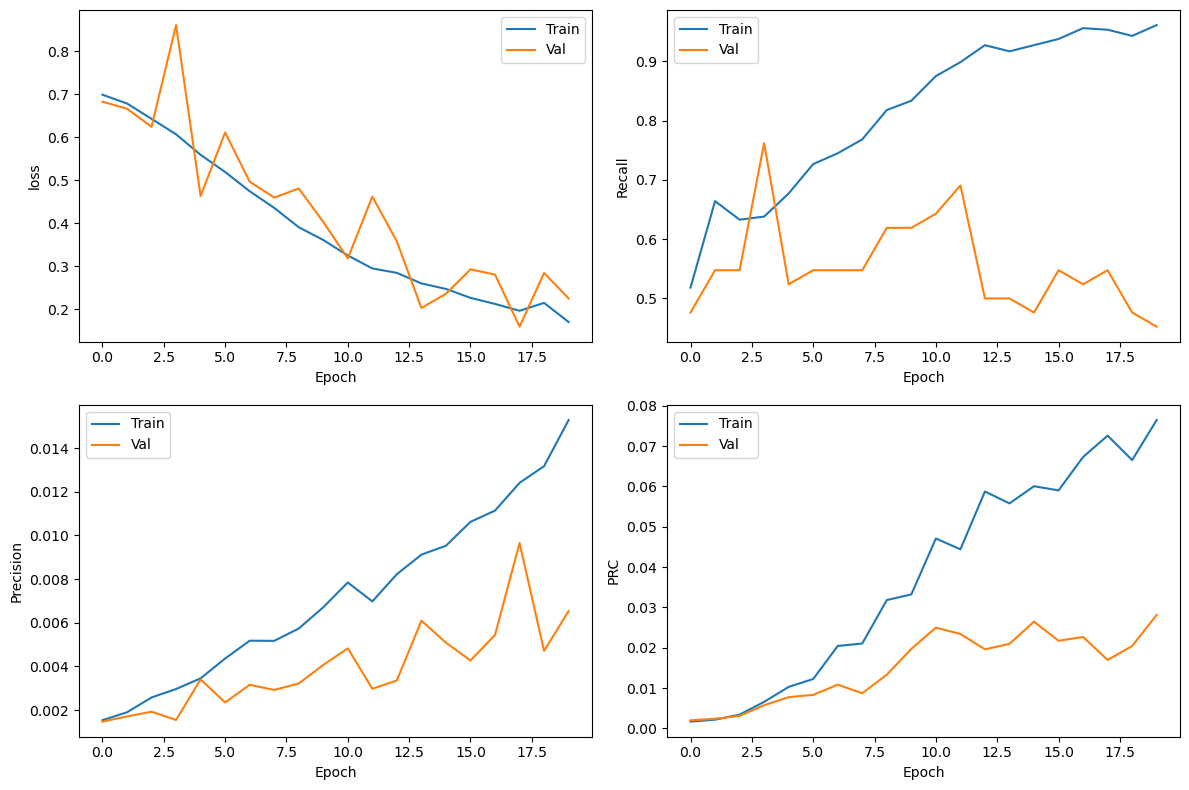

In [34]:
plot_training_metrics(history_class_weights)

In [35]:
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

34/34 [==============================] - 0s 2ms/step


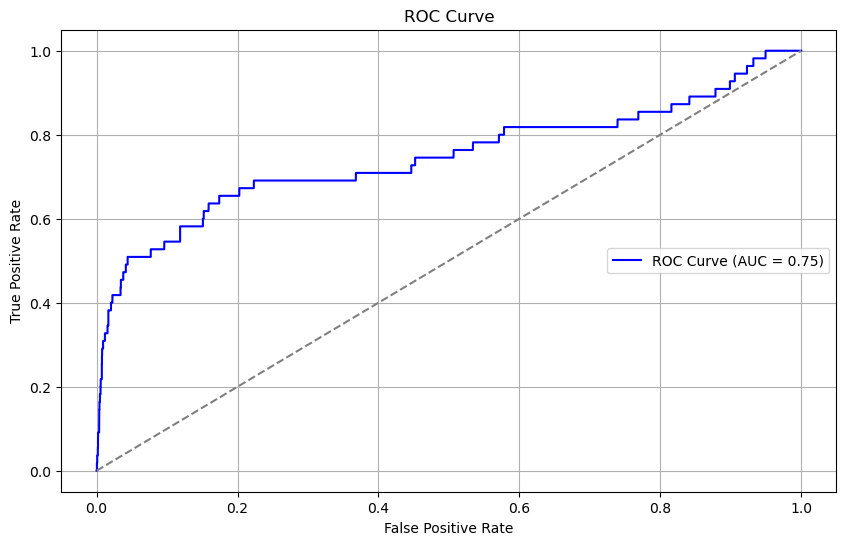

In [36]:
plot_roc_curve(Y_test, test_predictions)

/home/ykh/Repos/CreditCardApproval/Models/Functions.py:32: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


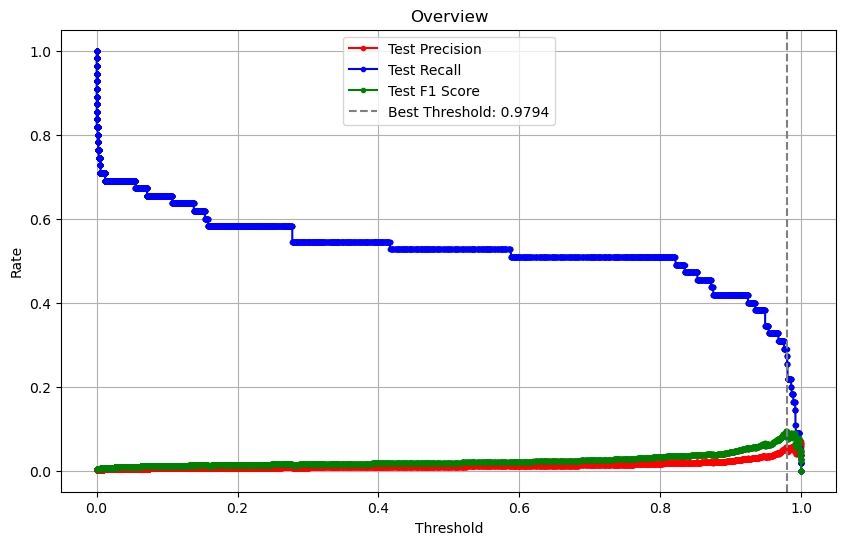

In [37]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

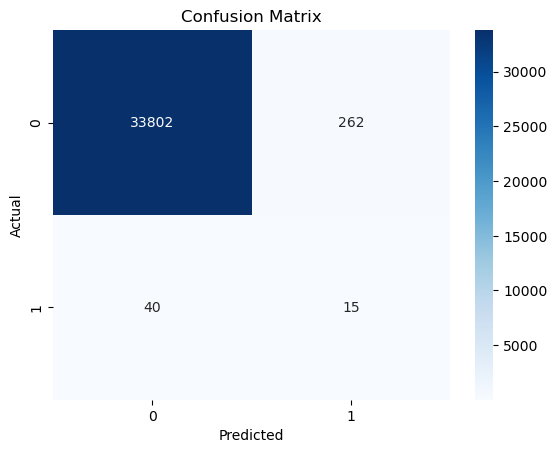

Recall       = 0.27
Precision    = 0.05
F1           = 0.09


In [38]:
get_result(Y_test, test_predictions, best_threshold)

### Using oversampling 

In [7]:
# Get the IDs of the risky customers in the training set
risk_ids = Y_train[Y_train==1].index.drop_duplicates()

# Split the training set into normal and risky
X_train_normal = X_train[~X_train.index.isin(risk_ids)]
X_train_risk = X_train[X_train.index.isin(risk_ids)]

Y_train_normal = Y_train[~Y_train.index.isin(risk_ids)]
Y_train_risk = Y_train[Y_train.index.isin(risk_ids)]

print(f'Number of normal customers :', len(Y_train_normal))
print(f'Number of risky customers :', len(Y_train_risk))

Number of normal customers : 272560
Number of risky customers : 384


In [8]:
# Select risky customers at random until there is as many risky customers as normal customers 
choices = np.random.choice(X_train_risk.index, len(X_train_normal))

X_train_risk_oversampled = X_train_risk.loc[choices]
Y_train_risk_oversampled = Y_train_risk.loc[choices]

print(f'Number of risky customers (oversampled) :', X_train_risk_oversampled.shape)

Number of risky customers (oversampled) : (272560, 53)


In [9]:
# Merge the oversampled dataset with risky customers with the dataset containing normal customers 
X_train_oversampled = np.concatenate([X_train_normal, X_train_risk_oversampled], axis=0)
y_train_oversampled = np.concatenate([Y_train_normal, Y_train_risk_oversampled], axis=0)

# Shuffle the order of risky and normal customers
order = np.arange(len(y_train_oversampled))
np.random.shuffle(order)

X_train_oversampled = X_train_oversampled[order]
y_train_oversampled = y_train_oversampled[order]

In [46]:
model = get_simple_model()

history_oversampled = model.fit(
    X_train_oversampled,
    y_train_oversampled,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
533/533 [==============================] - 7s 11ms/step - loss: 0.1089 - Accuracy: 0.9555 - Precision: 0.9491 - Recall: 0.9627 - PRC: 0.9910 - val_loss: 0.0590 - val_Accuracy: 0.9877 - val_Precision: 0.0436 - val_Recall: 0.4286 - val_PRC: 0.0418
Epoch 2/20
533/533 [==============================] - 6s 10ms/step - loss: 0.0213 - Accuracy: 0.9955 - Precision: 0.9921 - Recall: 0.9990 - PRC: 0.9970 - val_loss: 0.0421 - val_Accuracy: 0.9931 - val_Precision: 0.0783 - val_Recall: 0.4286 - val_PRC: 0.0526
Epoch 3/20
533/533 [==============================] - 5s 10ms/step - loss: 0.0166 - Accuracy: 0.9968 - Precision: 0.9942 - Recall: 0.9995 - PRC: 0.9972 - val_loss: 0.0401 - val_Accuracy: 0.9930 - val_Precision: 0.0769 - val_Recall: 0.4286 - val_PRC: 0.0578
Epoch 4/20
533/533 [==============================] - 5s 10ms/step - loss: 0.0153 - Accuracy: 0.9971 - Precision: 0.9946 - Recall: 0.9996 - PRC: 0.9973 - val_loss: 0.0449 - val_Accuracy: 0.9927 - val_Precision: 0.0741 - val_Recal

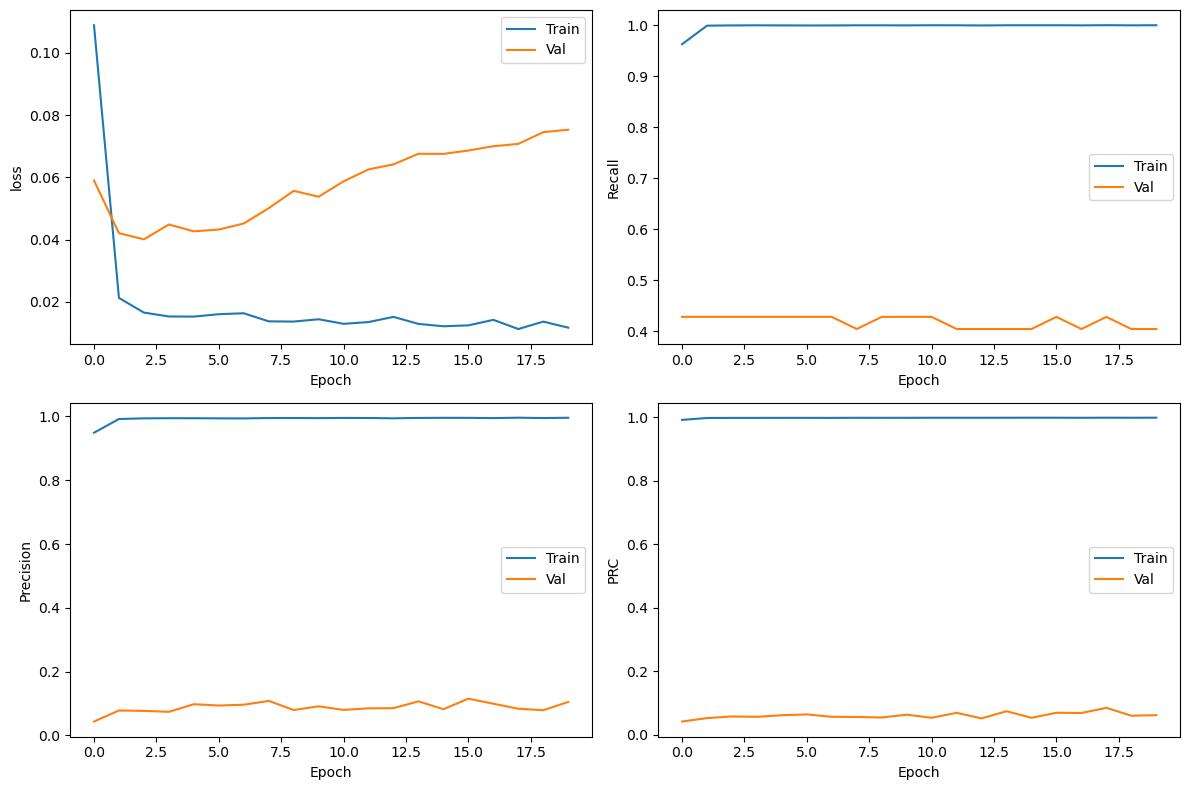

In [47]:
plot_training_metrics(history_oversampled)

In [54]:
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

34/34 [==============================] - 0s 2ms/step


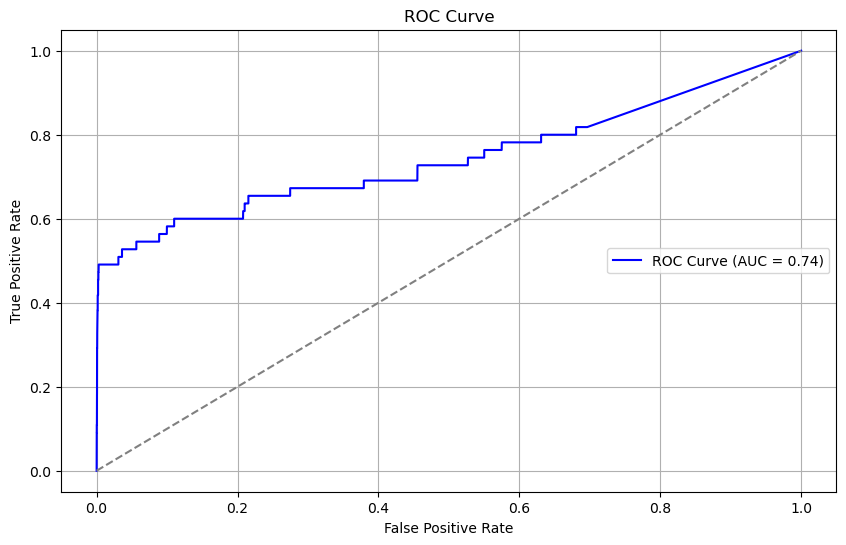

In [55]:
plot_roc_curve(Y_test, test_predictions)

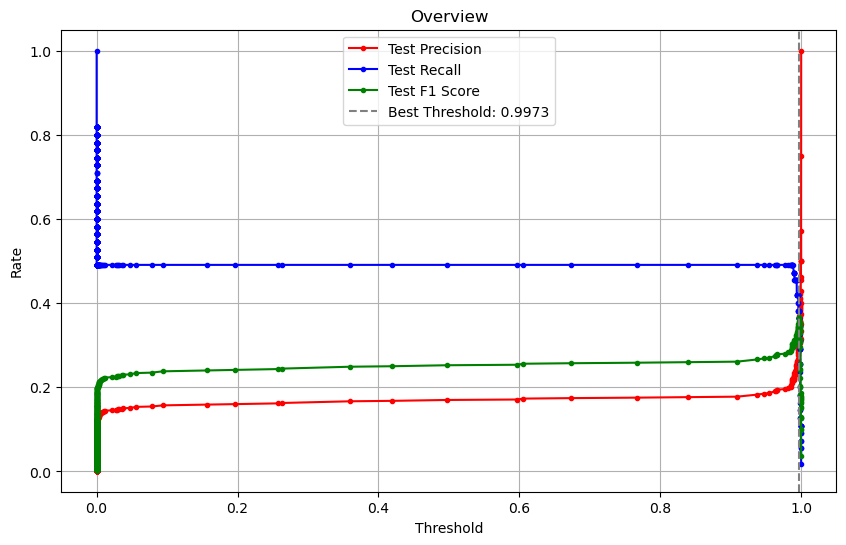

In [50]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

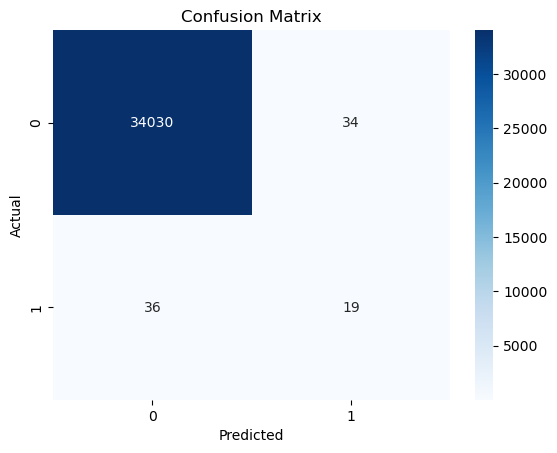

Recall       = 0.35
Precision    = 0.36
F1           = 0.35


In [51]:
get_result(Y_test, test_predictions, best_threshold)

### Results of the experiment
- All the models could use some regularization (we will handle that later)
- Using nothing to handle the imbalance did okay but not good (was not the point here)
- Using class weights was the worst of the three models
    - Could be the result of too high a weight for the risky customers and too low for the normal customers, which would mean that the model focuses more on reducing errors for risky customers. However, it did not do much better on the recall anyway. Trying out different weights could improve the performance.
- Using oversampling was the the best but again not really good.

Handling imbalance is clearly an important part to create a good model. However as demonstrated, you need to test out different methods to find out what works best.

## Find the best model
Lets try to find the possible model. To do that we'll create a function that can build a model with different hyperparameters.

In [16]:
def model_builder(hp):
    """
    Build and compile a model using hyperparameters defined in Keras Tuner.

    Args:
        hp (kt.HyperParameters): Object for defining hyperparameter search space.

    Returns:
        model: A compiled Keras model.
    """

    batch_size = hp.Int("batch_size", min_value=32, max_value=256, step=32)

    model = Sequential()
    model.add(Dense(
        units=hp.Int("input_layer", min_value=16, max_value=128, step=16), 
        input_shape=(X_train_oversampled.shape[1],),
        activation='relu',
        kernel_regularizer=l2(hp.Float(f"l2_0", min_value=0.0001, max_value=0.01, step=0.0001))
    ))

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(Dense(
            # Tune the number of units
            units=hp.Int(f"units_{i+1}", min_value=32, max_value=512, step=32),
            activation='relu',
            kernel_regularizer=l2(hp.Float(f"l2_{i}", min_value=0.0001, max_value=0.01, step=0.0001))
        ))

        # Optionally add Dropout and BatchNormalization
        if hp.Boolean(f"dropout_{i}"):
            model.add(Dropout(rate=hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.5, step=0.1)))
        if hp.Boolean(f"batch_norm_{i}"):
            model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])), # Tune the leraning rate
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='Accuracy'),
            Precision(name='Precision'), 
            Recall(name='Recall'), 
            AUC(name='prc', curve='PR') # Precision-Recall curve
        ])
    
    return model

In [17]:
monitor = 'val_prc'

In [18]:
model_builder(kt.HyperParameters())

tuner = kt.RandomSearch(
    hypermodel=model_builder,
    objective=kt.Objective(monitor, direction="max"),  # Objective to optimize
    max_trials=3,                                       # Number of trials to run during the search
    executions_per_trial=2,                             # Models that should be built and fit for each trial
    overwrite=True,                                     # Overwrite the previous results
    directory="Saved models",
    project_name="NN_Model_tuner",
)

tuner.search_space_summary()

Search space summary
Default search space size: 8
batch_size (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
input_layer (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
l2_0 (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': 0.0001, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Boolean)
{'default': False, 'conditions': []}
batch_norm_0 (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


We are going to utilize some callbacks when running the RandomSearch:
- ModelCheckpoint: To save the best weights depending on a monitored metric.
- EarlyStopping: To stop training when the model stop to improve on the monitored metric for a number of epochs. Here we also restore the weights, which resulted in the best performence on the monitored metric.

In [19]:
# Model checkpoint callback for securing best weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=r'tmp/tuner/best_checkpoint.h5',
    save_weights_only=False,            # Save the entire model (architecture + weights)
    monitor=monitor,
    mode='max',
    save_best_only=True
)

In [20]:
# Early stopping callback for efficient training
early_stopping = EarlyStopping(
    monitor=monitor,
    patience=4,
    mode='max',
    restore_best_weights=True
)

In [21]:
tuner.search(
    X_train_oversampled,
    y_train_oversampled,
    epochs=20,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, model_checkpoint_callback]
)

Trial 3 Complete [00h 32m 25s]
val_prc: 0.04866215959191322

Best val_prc So Far: 0.04866215959191322
Total elapsed time: 01h 10m 49s


In [22]:
# See the result of all the models
tuner.results_summary()

Results summary
Results in Saved models/NN_Model_tuner
Showing 10 best trials
Objective(name="val_prc", direction="max")

Trial 2 summary
Hyperparameters:
batch_size: 192
input_layer: 112
l2_0: 0.008199999999999999
num_layers: 4
units_1: 288
dropout_0: False
batch_norm_0: True
learning_rate: 0.001
dropout_rate_0: 0.2
units_2: 512
l2_1: 0.006
dropout_1: True
batch_norm_1: False
dropout_rate_1: 0.1
units_3: 32
l2_2: 0.0001
dropout_2: False
batch_norm_2: False
units_4: 32
l2_3: 0.0001
dropout_3: False
batch_norm_3: False
Score: 0.04866215959191322

Trial 1 summary
Hyperparameters:
batch_size: 256
input_layer: 112
l2_0: 0.0092
num_layers: 2
units_1: 320
dropout_0: True
batch_norm_0: True
learning_rate: 0.001
dropout_rate_0: 0.5
units_2: 416
l2_1: 0.006600000000000001
dropout_1: False
batch_norm_1: True
Score: 0.04058765806257725

Trial 0 summary
Hyperparameters:
batch_size: 160
input_layer: 128
l2_0: 0.0085
num_layers: 2
units_1: 160
dropout_0: True
batch_norm_0: True
learning_rate: 0.01
d

In [26]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_batch_size = best_hps.get("batch_size")
for value in best_hps.values:
    print(value, ':', best_hps.values[value])  # Inspect the hyperparameter values

batch_size : 192
input_layer : 112
l2_0 : 0.008199999999999999
num_layers : 4
units_1 : 288
dropout_0 : False
batch_norm_0 : True
learning_rate : 0.001
dropout_rate_0 : 0.2
units_2 : 512
l2_1 : 0.006
dropout_1 : True
batch_norm_1 : False
dropout_rate_1 : 0.1
units_3 : 32
l2_2 : 0.0001
dropout_2 : False
batch_norm_2 : False
units_4 : 32
l2_3 : 0.0001
dropout_3 : False
batch_norm_3 : False


In [27]:
# Build the best model
best_model = tuner.hypermodel.build(best_hps)

In [28]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=r'Saved models/NN_best_model.keras',
    save_weights_only=False,
    monitor=monitor,
    mode='max',
    save_best_only=True
)

In [29]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # directory to store logs
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [30]:
# Train the best model and capture the training history
history_best = best_model.fit(
    X_train_oversampled,
    y_train_oversampled,
    validation_data=(X_val, Y_val),
    epochs=50, 
    batch_size=best_batch_size,
    callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback]
)

Epoch 1/50
2840/2840 [==============================] - 32s 11ms/step - loss: 0.3604 - Accuracy: 0.9698 - Precision: 0.9619 - Recall: 0.9784 - prc: 0.9907 - val_loss: 0.1779 - val_Accuracy: 0.9815 - val_Precision: 0.0257 - val_Recall: 0.3810 - val_prc: 0.0293
Epoch 2/50
2840/2840 [==============================] - 30s 11ms/step - loss: 0.1527 - Accuracy: 0.9847 - Precision: 0.9782 - Recall: 0.9915 - prc: 0.9941 - val_loss: 0.2032 - val_Accuracy: 0.9645 - val_Precision: 0.0149 - val_Recall: 0.4286 - val_prc: 0.0346
Epoch 3/50
2840/2840 [==============================] - 29s 10ms/step - loss: 0.1318 - Accuracy: 0.9866 - Precision: 0.9807 - Recall: 0.9927 - prc: 0.9948 - val_loss: 0.1600 - val_Accuracy: 0.9764 - val_Precision: 0.0237 - val_Recall: 0.4524 - val_prc: 0.0363
Epoch 4/50
2840/2840 [==============================] - 29s 10ms/step - loss: 0.1225 - Accuracy: 0.9873 - Precision: 0.9815 - Recall: 0.9933 - prc: 0.9948 - val_loss: 0.1471 - val_Accuracy: 0.9784 - val_Precision: 0.0259

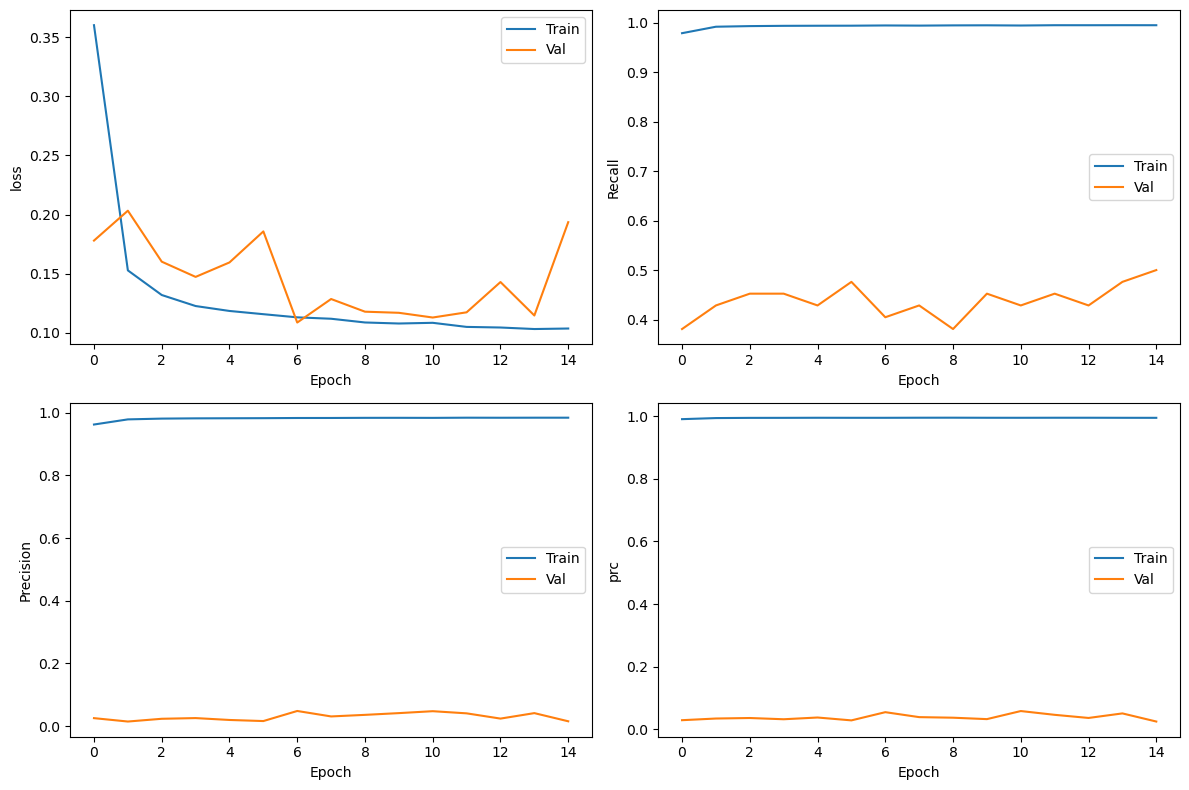

In [34]:
plot_training_metrics(history_best)

In [35]:
# Test model on test set
test_predictions = best_model.predict(X_test, batch_size=best_batch_size)

178/178 [==============================] - 0s 2ms/step


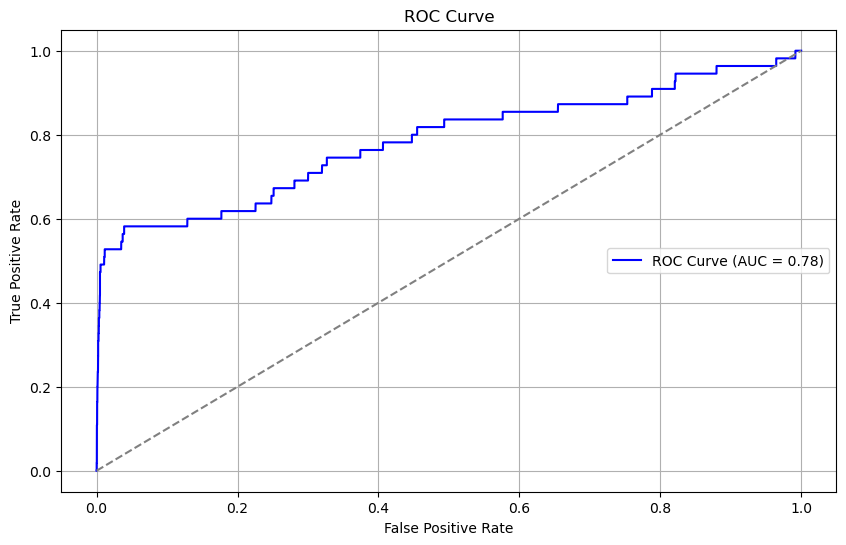

0.7840708932917716

In [36]:
plot_roc_curve(Y_test, test_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:64: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


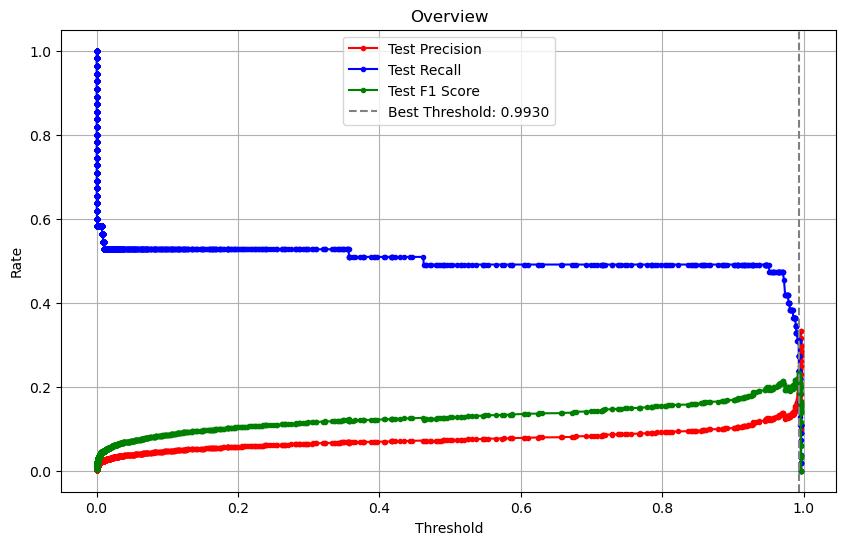

In [37]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

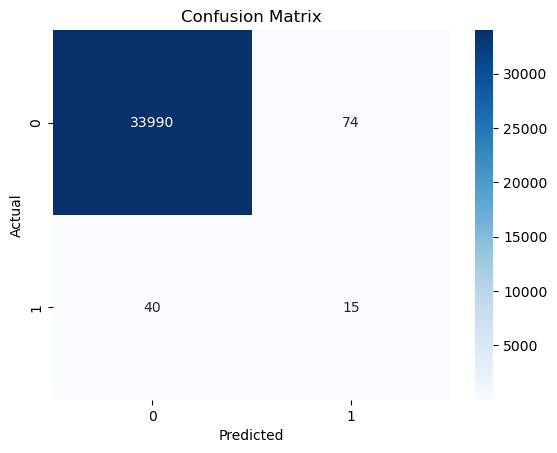

Recall       = 0.27
Precision    = 0.17
F1           = 0.21


In [38]:
_ = get_result(Y_test, test_predictions, best_threshold)